In [1]:
%cd /content/drive/MyDrive/boda2

!pip install pytorch-lightning==1.9
!pip install cloudml-hypertune
!pip install dmslogo
!pip install biopython

from google.colab import output
output.clear()

In [2]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

import pickle
from datetime import datetime
import scipy.stats as stats
import math

import hypertune
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import boda
from boda.common import constants, utils
from boda.common.utils import *

from src.main import unpack_artifact, model_fn
from src.pymeme import streme, parse_streme_output
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm
from boda.data import MPRA_DataModule

from boda.common.utils import batch2fasta

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

import dmslogo
%matplotlib inline

GPU available: Tesla V100-SXM2-16GB (1 count)


In [3]:
# class constants():
#     def __init__(self):
#         self.STANDARD_NT = ['A','C','G','T']
#         self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
# constants = constants()

class utils():
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor

    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT,
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

In [31]:
def dna2tensor_approx(sequence_str, vocab_list=constants.STANDARD_NT):
    seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
    for letterIdx, letter in enumerate(sequence_str):
        try:
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        except:
            seq_tensor[:, letterIdx] = 0
    seq_tensor = torch.Tensor(seq_tensor)
    return seq_tensor

def df_to_onehot_tensor(in_df, seq_column='nt_sequence'):
    onehot_sequences = torch.stack([dna2tensor_approx(subsequence) \
                                for subsequence in tqdm(in_df[seq_column])])
    return onehot_sequences

class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1,
                 dual_pred=False):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis
        self.dual_pred = dual_pred

        try: self.model.eval()
        except: pass

        self.register_flanks()

    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        if self.dual_pred:
            dual_tensor = utils.reverse_complement_onehot(in_tensor)
            out_tensor = self.model(in_tensor)[:, self.pred_idx] + self.model(dual_tensor)[:, self.pred_idx]
            out_tensor = out_tensor / 2.0
        else:
            out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor

    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank)


def isg_contributions(sequences,
                      predictor,
                      num_steps=100,
                      max_samples=20,
                      eval_batch_size=1024,
                      theta_factor=15,
                      adaptive_sampling=True
                     ):

    batch_size = eval_batch_size // (max_samples - 3)
    temp_dataset = TensorDataset(sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    slope_coefficients = [i / num_steps for i in range(1, num_steps + 1)]
    if adaptive_sampling:
        sneaky_exponent = np.log(max_samples - 3) / np.log(num_steps)
        sample_ns = np.flip((np.arange(0, num_steps)**sneaky_exponent).astype(int)).clip(min=2)
    else:
        sample_ns = [max_samples for i in range(0, num_steps + 1)]

    all_salient_maps = []
    all_gradients = []
    for local_batch in tqdm(temp_dataloader):
        target_thetas = (theta_factor * local_batch[0].cuda()).requires_grad_()
        line_gradients = []
        for i in range(0, num_steps):
            point_thetas = slope_coefficients[i] * target_thetas
            num_samples = sample_ns[i]
            point_distributions = F.softmax(point_thetas, dim=-2)
            nucleotide_probs = Categorical(torch.transpose(point_distributions, -2, -1))
            sampled_idxs = nucleotide_probs.sample((num_samples, ))
            sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=4)
            sampled_nucleotides = torch.transpose(sampled_nucleotides_T, -2, -1)
            distribution_repeater = point_distributions.repeat(num_samples, *[1, 1, 1])
            sampled_nucleotides = sampled_nucleotides - distribution_repeater.detach() + distribution_repeater
            samples = sampled_nucleotides.flatten(0,1)
            preds = predictor(samples)
            point_predictions = preds.unflatten(0, (num_samples, target_thetas.shape[0])).mean(dim=0)
            point_gradients = torch.autograd.grad(point_predictions.sum(), inputs=point_thetas, retain_graph=True)[0]
            line_gradients.append(point_gradients)

        gradients = torch.stack(line_gradients).mean(dim=0).detach()
        all_salient_maps.append(gradients * target_thetas.detach())
        all_gradients.append(gradients)
    return torch.cat(all_salient_maps).cpu(), theta_factor * torch.cat(all_gradients).cpu()

def ppm_to_meme_format(ppm, motif_name):
    """
    Convert a PPM to MEME suite format.

    Args:
    ppm (numpy.ndarray): The Position Probability Matrix (PPM).
    motif_name (str): The name of the motif.

    Returns:
    str: The motif in MEME suite format.
    """
    ppm_string = f"MOTIF {motif_name}\n"
    ppm_string += f"letter-probability matrix: alength= 4 w= {ppm.shape[1]}\n"

    for i in range(ppm.shape[1]):
        col = ppm[:, i]
        ppm_string += " ".join(map(str, col)) + "\n"

    return ppm_string

def write_meme_file(motif_list, motif_names, output_filename):
    """
    Write motifs to a .meme file in MEME suite format.

    Args:
    motif_list (list of numpy.ndarray): List of PPMs.
    motif_names (list of str): List of motif names.
    output_filename (str): The name of the output .meme file.
    """
    with open(output_filename, "w") as f:
        f.write("MEME version 4\n\n")
        f.write("ALPHABET= ACGT\n\n")
        f.write("strands: + -\n\n")
        f.write("Background letter frequencies:\n")
        f.write("A 0.25 C 0.25 G 0.25 T 0.25\n\n")

        for i, motif in enumerate(motif_list):
            meme_format = ppm_to_meme_format(motif, motif_names[i])
            f.write(meme_format)
            f.write("\n")

# Load Malinois

In [5]:
model_dir = './artifacts'
model = model_fn(model_dir)
model.cuda()
model.eval()
print('')

Loaded model from 20211113_021200 in eval mode



## Load CODA contributions

In [6]:
onehots_dict = torch.load('/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_onehots.pt')

cell_types = ['K562', 'HepG2', 'SKNSH']

contributions_dicts = {}
for cell_type in cell_types:
  contributions_dicts[cell_type] = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_contributions_{cell_type}.pt')

all_contributions = torch.stack([contributions_dicts[cell_type]['contributions'] for cell_type in cell_types], dim=0)
all_hyp_contributions = torch.stack([contributions_dicts[cell_type]['hyp_contributions'] for cell_type in cell_types], dim=0)

cell_colors = ['#00A79D', '#FBB040', '#ED1C24']

# Load merged MoDISco results

In [7]:
pos_pattern_dict = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/merged_pos_patterns.pt')
neg_pattern_dict = torch.load(f'/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/merged_neg_patterns.pt')

##----- Save patterns to file --------
# all_patterns_hyp = []
# all_patterns_contrib = []
# all_names = []

# loaded_patterns = pos_pattern_dict['merged_pattern_hypscores']
# loaded_patterns_contrib = pos_pattern_dict['merged_pattern_scores']
# for pattern_idx in range(loaded_patterns.shape[0]):
#     all_patterns_hyp.append(loaded_patterns[pattern_idx, ...].T)
#     all_patterns_contrib.append(loaded_patterns_contrib[pattern_idx, ...].T)

# all_names += [f'pos_pattern_{i}' for i in range(loaded_patterns.shape[0])]

# loaded_patterns = np.stack(neg_pattern_dict['merged_pattern_hypscores'], axis=0)
# loaded_patterns_contrib = np.stack(neg_pattern_dict['merged_pattern_scores'], axis=0)
# for pattern_idx in range(loaded_patterns.shape[0]):
#     all_patterns_hyp.append(loaded_patterns[pattern_idx, ...].T)
#     all_patterns_contrib.append(loaded_patterns_contrib[pattern_idx, ...].T)

# all_names += [f'neg_pattern_{i}' for i in range(loaded_patterns.shape[0])]

# output_filename = "/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/merged_modisco_patterns_scores.txt"
# write_meme_file(all_patterns_contrib, all_names, output_filename)

# output_filename = "/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/merged_modisco_patterns_hypscores.txt"
# write_meme_file(all_patterns_hyp, all_names, output_filename)

### Positive patterns

In [ ]:
loaded_patterns = pos_pattern_dict['merged_pattern_hypscores']

pattern_ppms = []
pattern_icms = []
for pattern_idx in range(loaded_patterns.shape[0]):
    pattern_scores = loaded_patterns[pattern_idx, ...]

    plot_tensor = torch.Tensor(pattern_scores).T
    # y_max = plot_tensor.max()
    # matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
    #                     axisfontscale=0.6, heightscale=0.8)
    # plt.xlabel('')
    # plt.ylabel('')
    # plt.title(f'pos_pattern_{pattern_idx}')
    # plt.show()

    motif_pwm = torch.Tensor(pattern_scores).T
    motif_pwm = motif_pwm * 10 / motif_pwm.abs().sum(dim=0).max().item()
    motif_ppm = torch.softmax(motif_pwm, dim=0)
    motif_icm = ppm_to_IC(motif_ppm)

    pattern_ppms.append(motif_ppm)
    pattern_icms.append(motif_icm)

    # matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.8,
    #                     axisfontscale=0.6, heightscale=0.8)
    # plt.xlabel('')
    # plt.ylabel('')
    # plt.yticks([0,1,2])
    # plt.title(f'pos_pattern_{pattern_idx}')
    # plt.show()

    # print()

pos_pattern_ppms = pattern_ppms.copy()
pattern_ppms = torch.stack(pattern_ppms)

num_patterns = pattern_ppms.shape[0]

In [ ]:
n_samples = 10000

token_dim = -2
cat_axis = -1

left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)

pattern_ppms = torch.cat([pattern_ppms, 0.25 * torch.ones((1, 4, 30))])
random_prob_pad = 0.25 * torch.ones((pattern_ppms.shape[0], 4, 85))

probs = torch.cat([random_prob_pad, pattern_ppms, random_prob_pad], axis=-1)
probs_t = torch.transpose(probs, token_dim, cat_axis)
sampled_idxs = Categorical( probs_t )
samples = sampled_idxs.sample( (n_samples, ) )
samples = F.one_hot(samples, num_classes=4)
samples = torch.transpose(samples, token_dim, cat_axis)

pieces = [left_flank.repeat(samples.shape[0], samples.shape[1], 1, 1),
          samples,
          right_flank.repeat(samples.shape[0],samples.shape[1], 1, 1)]
in_tensor = torch.cat( pieces, axis=cat_axis)
in_tensor = in_tensor.flatten(0, 1)

In [ ]:
batch_size = 1024

temp_dataset = TensorDataset(in_tensor)
temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

preds = []
for local_batch in tqdm(temp_dataloader):
    preds.append(model(local_batch[0].cuda()).detach().cpu())

preds = torch.cat(preds, dim=0).unflatten(0, (n_samples, pattern_ppms.shape[0]))

  0%|          | 0/586 [00:00<?, ?it/s]

In [ ]:
for j in range(num_patterns):
    matrix_to_dms(pattern_icms[j], y_max=2, fontaspect=.55, widthscale=0.4,
                        axisfontscale=0.6, heightscale=0.4)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([0,1,2])
    plt.title(f'pos_pattern_{j}')
    plt.show()

    plt.figure(figsize=(4, 2))
    boxplot = plt.boxplot(preds[:, j, :].numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                          labels=[f'{cell_type}\n pattern' for cell_type in cell_types], patch_artist=True)
    boxplot_2 = plt.boxplot(preds[:, -1, :].numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                          labels=[f'{cell_type}\n random' for cell_type in cell_types], patch_artist=True)
    # Set fill colors for each box
    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=0.25)
    for median in boxplot_2['medians']:
        median.set(color='black')

    # for flier in boxplot['fliers']:
    #     flier.set(marker='.', markersize=2, markerfacecolor=flier.get_color())
    plt.ylabel('Predicted l2FC')
    # plt.xticks(rotation=90)
    plt.title(f'pos_pattern_{j}')
    plt.xticks(rotation=90)
    plt.show()

    print()

Output hidden; open in https://colab.research.google.com to view.

### Negative patterns

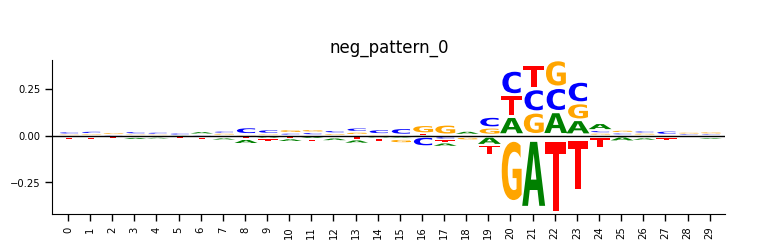

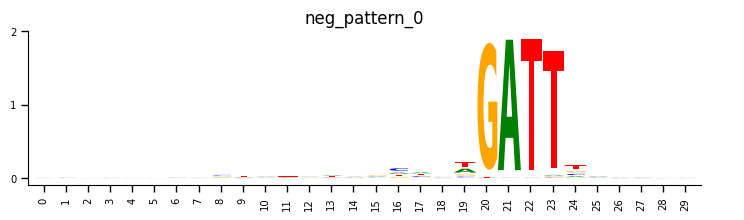

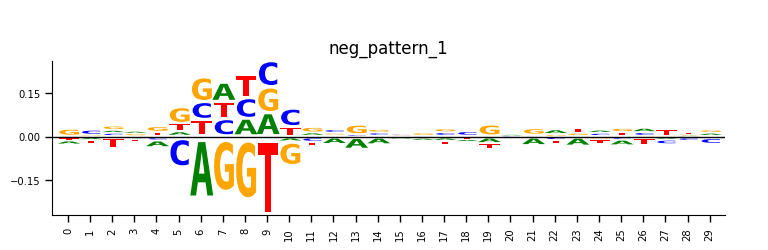

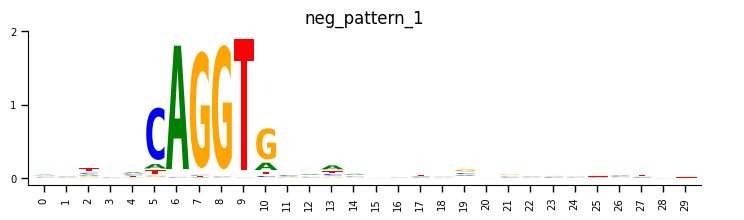

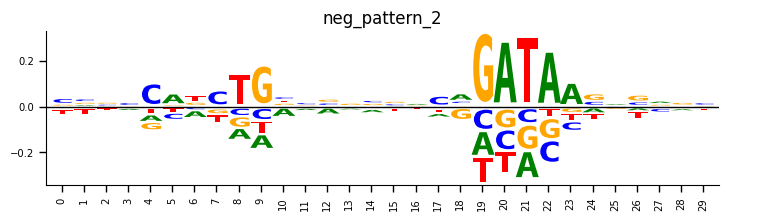

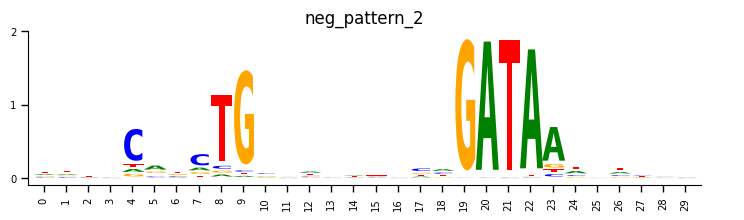

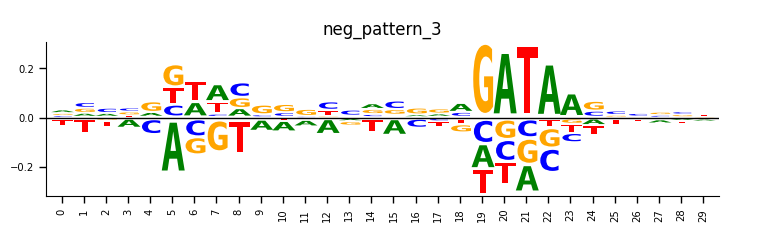

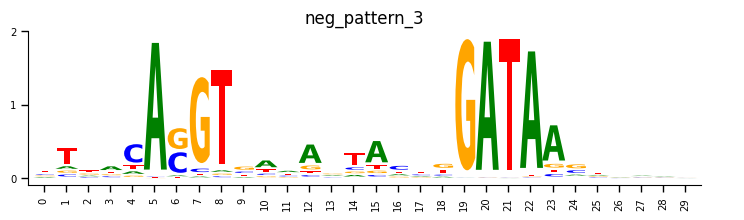

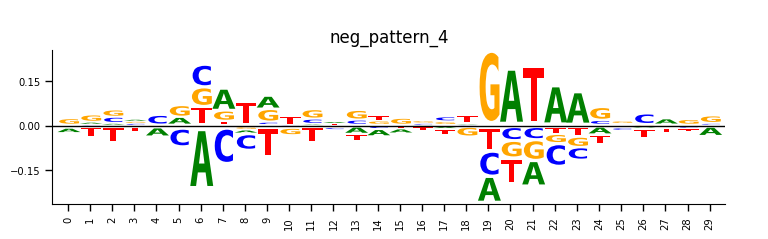

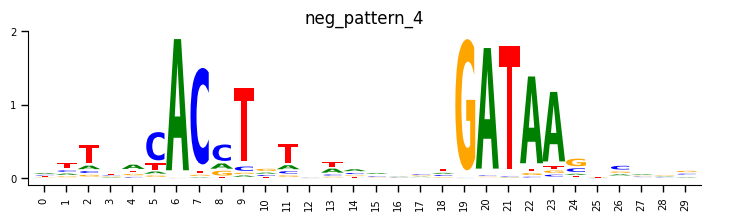

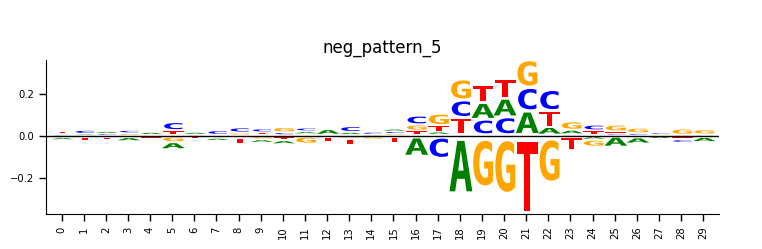

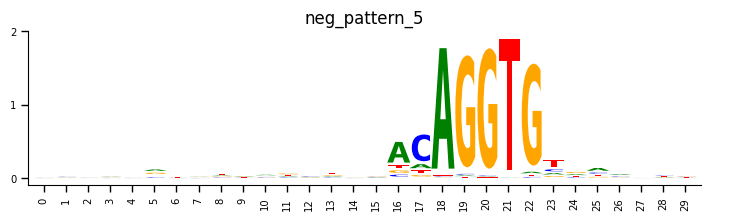

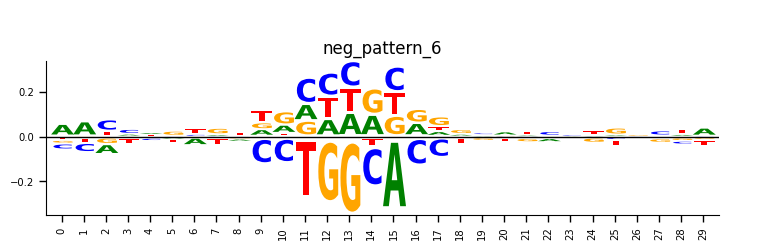

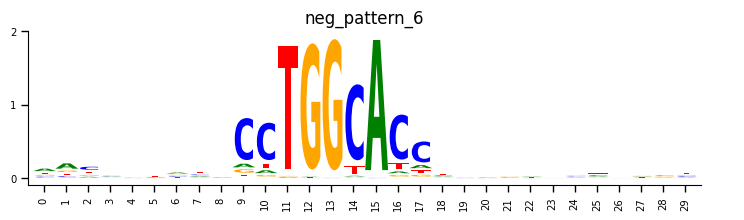

In [ ]:
loaded_patterns = np.stack(neg_pattern_dict['merged_pattern_hypscores'], axis=0)
loaded_patterns_contrib = np.stack(neg_pattern_dict['merged_pattern_scores'], axis=0)

pattern_ppms = []
pattern_icms = []
for pattern_idx in range(loaded_patterns.shape[0]):
    pattern_scores = loaded_patterns[pattern_idx, ...]
    pattern_scores_contrib = loaded_patterns_contrib[pattern_idx, ...]

    positive_filter = pattern_scores_contrib.sum(axis=1) >= 0
    sign_pattern = np.sign(1 * positive_filter) - 1.2 * ~positive_filter
    sign_pattern = sign_pattern.reshape(-1, 1)

    plot_tensor = torch.Tensor(pattern_scores).T
    y_max = (plot_tensor * (plot_tensor > 0)).sum(dim=0).max()
    matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
                        axisfontscale=0.6, heightscale=0.8)
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'neg_pattern_{pattern_idx}')
    plt.show()

    # plt.figure(figsize=(9, 1))
    # plt.plot(pattern_scores_contrib.sum(axis=1))
    # plt.hlines(0, 0, 30, color='black')
    # plt.show()

    # plt.figure(figsize=(10, 2))
    # plt.plot(pattern_scores_contrib.sum(axis=1))
    # plt.hlines(0, 0, 30, color='black')

    motif_pwm = torch.Tensor(sign_pattern * pattern_scores).T
    motif_pwm = motif_pwm * 10 / motif_pwm.abs().sum(dim=0).max().item()
    motif_ppm = torch.softmax(motif_pwm, dim=0)
    motif_icm = ppm_to_IC(motif_ppm)

    pattern_ppms.append(motif_ppm)
    pattern_icms.append(motif_icm)

    matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.8,
                        axisfontscale=0.6, heightscale=0.8)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([0,1,2])
    plt.title(f'neg_pattern_{pattern_idx}')
    plt.show()

    print()

neg_pattern_ppms = pattern_ppms.copy()
pattern_ppms = torch.stack(pattern_ppms)

num_patterns = pattern_ppms.shape[0]

In [ ]:
# all_pattern_ppms = {}
# for i in range(len(pos_pattern_ppms)):
#     all_pattern_ppms[f'pos_pattern_{i}'] = pos_pattern_ppms[i]
# for i in range(len(neg_pattern_ppms)):
#     all_pattern_ppms[f'neg_pattern_{i}'] = neg_pattern_ppms[i]

# torch.save(all_pattern_ppms, "/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_modisco_transformed_untrimmed_tensors.pt")

# motif_list = [ppm.numpy() for ppm in all_pattern_ppms.values()]
# motif_names = list(all_pattern_ppms.keys())

# output_filename = "/content/drive/MyDrive/data/BODA2_MPRA/CODA_contributions/CODA_modisco_transformed_untrimmed.txt"
# write_meme_file(motif_list, motif_names, output_filename)

In [ ]:
n_samples = 10000

token_dim = -2
cat_axis = -1

left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)

pattern_ppms = torch.cat([pattern_ppms, 0.25 * torch.ones((1, 4, 30))])
random_prob_pad = 0.25 * torch.ones((pattern_ppms.shape[0], 4, 85))

probs = torch.cat([random_prob_pad, pattern_ppms, random_prob_pad], axis=-1)
probs_t = torch.transpose(probs, token_dim, cat_axis)
sampled_idxs = Categorical( probs_t )
samples = sampled_idxs.sample( (n_samples, ) )
samples = F.one_hot(samples, num_classes=4)
samples = torch.transpose(samples, token_dim, cat_axis)

pieces = [left_flank.repeat(samples.shape[0], samples.shape[1], 1, 1),
          samples,
          right_flank.repeat(samples.shape[0],samples.shape[1], 1, 1)]
in_tensor = torch.cat( pieces, axis=cat_axis)
in_tensor = in_tensor.flatten(0, 1)

In [ ]:
batch_size = 1024

temp_dataset = TensorDataset(in_tensor)
temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

preds = []
for local_batch in tqdm(temp_dataloader):
    preds.append(model(local_batch[0].cuda()).detach().cpu())

preds = torch.cat(preds, dim=0).unflatten(0, (n_samples, pattern_ppms.shape[0]))

  0%|          | 0/79 [00:00<?, ?it/s]

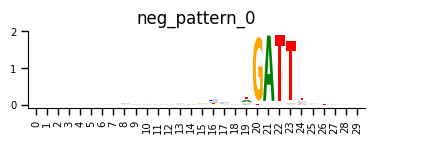

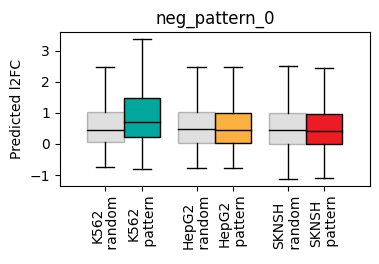

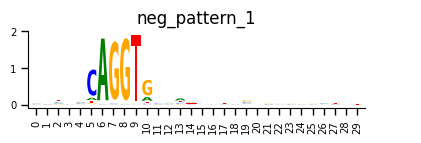

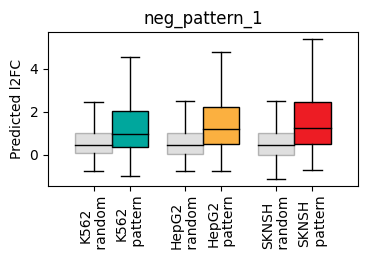

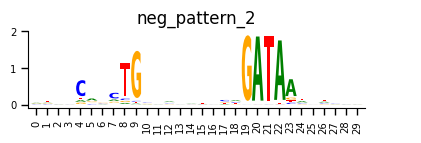

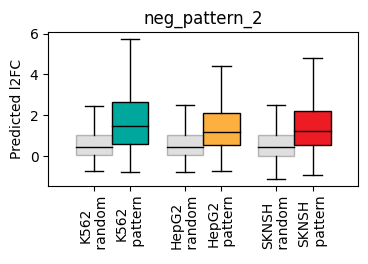

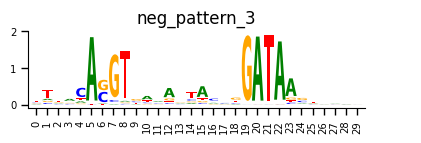

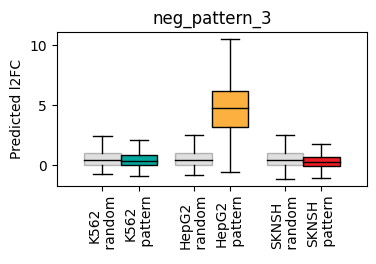

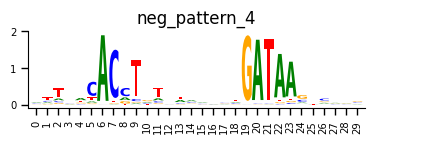

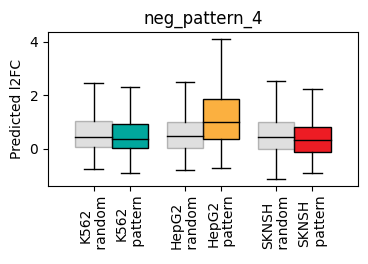

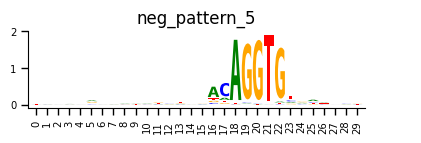

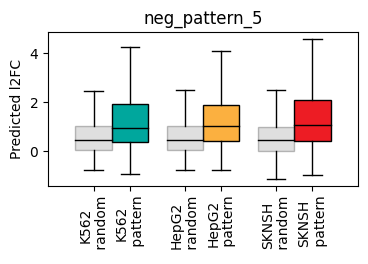

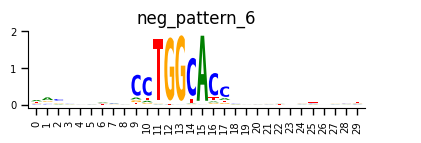

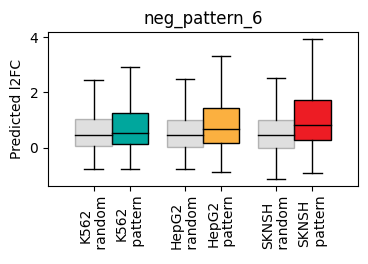

In [ ]:
for j in range(num_patterns):
    matrix_to_dms(pattern_icms[j], y_max=2, fontaspect=.55, widthscale=0.4,
                        axisfontscale=0.6, heightscale=0.4)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([0,1,2])
    plt.title(f'neg_pattern_{j}')
    plt.show()

    plt.figure(figsize=(4, 2))
    boxplot = plt.boxplot(preds[:, j, :].numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                          labels=[f'{cell_type}\n pattern' for cell_type in cell_types], patch_artist=True)
    boxplot_2 = plt.boxplot(preds[:, -1, :].numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                          labels=[f'{cell_type}\n random' for cell_type in cell_types], patch_artist=True)
    # Set fill colors for each box
    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=0.25)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.title(f'neg_pattern_{j}')
    plt.xticks(rotation=90)
    plt.show()

    print()

# Load STREME motifs

In [ ]:
boda2_streme_tfs = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/STREME_min8_TFs_merge.txt', sep=" ", low_memory=False)

df_array_columns = ['pfm', 'pwm', 'pwm_rc', 'pssm', 'pssm_rc', 'icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
for df_array_column in tqdm(df_array_columns):
    boda2_streme_tfs[df_array_column] = boda2_streme_tfs.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
probs = []
for i in range(len(boda2_streme_tfs)):
    motif_df = boda2_streme_tfs.iloc[i]
    motif_ppm = torch.Tensor(motif_df['pwm'])
    left_size, right_size = int(np.floor(motif_ppm.shape[1] / 2)), int(np.ceil(motif_ppm.shape[1] / 2))
    random_prob_left_pad = 0.25 * torch.ones((4, 100 - left_size))
    random_prob_right_pad = 0.25 * torch.ones((4, 100 - right_size))
    probs.append(torch.cat([random_prob_left_pad, motif_ppm, random_prob_right_pad], dim=-1))

probs.append(0.25 * torch.ones((4, 200)))
probs = torch.stack(probs)

In [ ]:
n_samples = 10000

token_dim = -2
cat_axis = -1

left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)

probs_t = torch.transpose(probs, token_dim, cat_axis)
sampled_idxs = Categorical( probs_t )
samples = sampled_idxs.sample( (n_samples, ) )
samples = F.one_hot(samples, num_classes=4)
samples = torch.transpose(samples, token_dim, cat_axis)

pieces = [left_flank.repeat(samples.shape[0], samples.shape[1], 1, 1),
          samples,
          right_flank.repeat(samples.shape[0], samples.shape[1], 1, 1)]
in_tensor = torch.cat( pieces, axis=cat_axis)
in_tensor = in_tensor.flatten(0, 1)

In [ ]:
batch_size = 1024

temp_dataset = TensorDataset(in_tensor)
temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

preds = []
for local_batch in tqdm(temp_dataloader):
    preds.append(model(local_batch[0].cuda()).detach().cpu())

preds = torch.cat(preds, dim=0).unflatten(0, (n_samples, probs.shape[0]))

  0%|          | 0/811 [00:00<?, ?it/s]

In [ ]:
for j in range(len(boda2_streme_tfs)):
    motif_df = boda2_streme_tfs.iloc[j]
    motif_icm = torch.Tensor(motif_df['icm'])
    motif_id = motif_df['ultimate_id']

    matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.6,
                        axisfontscale=0.6, heightscale=0.4)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([0,1,2])
    plt.title(f'{motif_id}')
    plt.show()

    plt.figure(figsize=(4, 2))
    boxplot = plt.boxplot(preds[:, j, :].numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                          labels=[f'{cell_type}\n pattern' for cell_type in cell_types], patch_artist=True)
    boxplot_2 = plt.boxplot(preds[:, -1, :].numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                          labels=[f'{cell_type}\n random' for cell_type in cell_types], patch_artist=True)
    # Set fill colors for each box
    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=0.25)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.title(f'{motif_id}')
    plt.xticks(rotation=90)
    plt.show()

    print()

Output hidden; open in https://colab.research.google.com to view.

### Contribution-based STREME motifs

In [ ]:
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)

row_filter_1 = boda2_df['method'].isin(['DHS', 'gs', 'sa', 'al']) & (boda2_df['round'] == 0)
precise_library_df = boda2_df[row_filter_1 | (boda2_df['method'] == 'fsp') ].reset_index(drop=True)

In [ ]:
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/fimo_min8.tsv', sep='\t')
fimo_df = fimo_df[:-3].reset_index(drop=True)

fimo_df['start'] = fimo_df['start'].to_numpy() - 1 #np.maximum(0, fimo_df['start'].to_numpy() - 1)
fimo_df['stop'] = fimo_df['stop'].to_numpy() + 0 #np.minimum(200, fimo_df['stop'].to_numpy() + 0)
fimo_df['start'] = fimo_df['start'].astype(int)
fimo_df['stop'] = fimo_df['stop'].astype(int)

fimo_df = fimo_df[fimo_df['sequence_name'].isin(precise_library_df['ID'].to_list())].reset_index(drop=True)

In [ ]:
motif_list = boda2_streme_tfs['name'].tolist()

id2idx_dict = dict(zip(precise_library_df['ID'], precise_library_df.index))

all_fwd_motif_contributions = []
all_rev_motif_contributions = []

all_fwd_motif_hyp_contributions = []
all_rev_motif_hyp_contributions = []
for motif_id in tqdm(motif_list):
    motif_fimo_df = fimo_df[fimo_df['motif_id'] == motif_id]
    #Forward hits
    strand_motif_fimo_df = motif_fimo_df[motif_fimo_df['strand'] == '+'].reset_index(drop=True)
    motif_starts = strand_motif_fimo_df['start'].tolist()
    motif_stops = strand_motif_fimo_df['stop'].tolist()
    motif_seq_ids = strand_motif_fimo_df['sequence_name'].tolist()
    seq_idxs = [id2idx_dict[id] for id in motif_seq_ids]
    motif_contributions = []
    motif_hyp_contributions = []
    iterator = zip(seq_idxs, zip(motif_starts, motif_stops))
    for seq_idx, (start, stop) in iterator:
        motif_contributions.append(all_contributions[:, seq_idx, ..., start:stop])
        motif_hyp_contributions.append(all_hyp_contributions[:, seq_idx, ..., start:stop])
    all_fwd_motif_contributions.append(torch.stack(motif_contributions).mean(dim=0))
    all_fwd_motif_hyp_contributions.append(torch.stack(motif_hyp_contributions).mean(dim=0))

    #Reverse complement hits
    strand_motif_fimo_df = motif_fimo_df[motif_fimo_df['strand'] == '-'].reset_index(drop=True)
    motif_starts = strand_motif_fimo_df['start'].tolist()
    motif_stops = strand_motif_fimo_df['stop'].tolist()
    motif_seq_ids = strand_motif_fimo_df['sequence_name'].tolist()
    seq_idxs = [id2idx_dict[id] for id in motif_seq_ids]
    motif_contributions = []
    motif_hyp_contributions = []
    iterator = zip(seq_idxs, zip(motif_starts, motif_stops))
    for seq_idx, (start, stop) in iterator:
        motif_contributions.append(all_contributions[:, seq_idx, ..., start:stop])
        motif_hyp_contributions.append(all_hyp_contributions[:, seq_idx, ..., start:stop])
    all_rev_motif_contributions.append(torch.stack(motif_contributions).mean(dim=0))
    all_rev_motif_hyp_contributions.append(torch.stack(motif_hyp_contributions).mean(dim=0))

  0%|          | 0/82 [00:00<?, ?it/s]

In [ ]:
consensus_onehots = [utils.dna2tensor(seq) for seq in boda2_streme_tfs['consensus'].tolist()]

all_corrected_ppms = []
all_corrected_icms = []
all_preferred_cell_idxs = []
for i in range(82):
    motif_name = boda2_streme_tfs.iloc[i]['ultimate_id']
    plot_tensor = torch.Tensor(boda2_streme_tfs.iloc[i]['icm'])
    matrix_to_dms(plot_tensor, y_max=2, fontaspect=.55, widthscale=0.4,
                        axisfontscale=0.6, heightscale=0.4)
    plt.yticks([0,1,2])
    plt.xlabel('')
    plt.ylabel('')
    # for spine in plt.gca().spines.values():
    #         spine.set_visible(False)
    plt.title(motif_name, y=1.05, loc='left', fontsize=10)
    plt.show()

    consensus_onehot = consensus_onehots[i]
    fwd_motif_hyp_contributions = all_fwd_motif_hyp_contributions[i]
    rev_motif_hyp_contributions = all_rev_motif_hyp_contributions[i]
    motif_hyp_contributions = fwd_motif_hyp_contributions + utils.reverse_complement_onehot(rev_motif_hyp_contributions)

    consensus_contributions = motif_hyp_contributions * consensus_onehot.reshape(1, 4, -1)
    preferred_cell_idx = consensus_contributions.sum(dim=[1,2]).abs().argmax().item()
    consensus_contribution_max = consensus_contributions[preferred_cell_idx].abs().max()
    directionality = torch.sign(consensus_contributions.sum(dim=[1,2])[preferred_cell_idx]).item()

    all_preferred_cell_idxs.append(preferred_cell_idx)

    #print(f'Contribution max {np.round(consensus_contribution_max.abs().item(), 2)}')

    motif_pwm = directionality * motif_hyp_contributions[preferred_cell_idx,...]
    motif_pwm = motif_pwm * 10 / motif_pwm.abs().sum(dim=0).max().item()
    motif_ppm = torch.softmax(motif_pwm, dim=0)
    motif_icm = ppm_to_IC(motif_ppm)

    all_corrected_ppms.append(motif_ppm)
    all_corrected_icms.append(motif_icm)

    #print(f'Contribution-corrected M-{i + 1} (cell={preferred_cell_idx})')
    matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.4,
                                axisfontscale=0.6, heightscale=0.4)
    plt.yticks([0,1,2])
    plt.xlabel('')
    plt.ylabel('')
    # for spine in plt.gca().spines.values():
    #         spine.set_visible(False)
    plt.title(f'M-{i + 1} contribution-based (cell={preferred_cell_idx}, c={np.round(consensus_contribution_max.abs().item(), 2)})',
              y=1.05, loc='left', fontsize=7)
    plt.show()

    print()
    print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# motif_list = [ppm.numpy() for ppm in all_corrected_ppms]
# motif_names = boda2_streme_tfs['name'].tolist()

# output_filename = "/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/STREME_min8_contribution_projections.txt"
# write_meme_file(motif_list, motif_names, output_filename)

#Emmbedding corrected STREME motifs

In [ ]:
probs = []
for i in range(len(boda2_streme_tfs)):
    motif_ppm = all_corrected_ppms[i]
    left_size, right_size = int(np.floor(motif_ppm.shape[1] / 2)), int(np.ceil(motif_ppm.shape[1] / 2))
    random_prob_left_pad = 0.25 * torch.ones((4, 100 - left_size))
    random_prob_right_pad = 0.25 * torch.ones((4, 100 - right_size))
    probs.append(torch.cat([random_prob_left_pad, motif_ppm, random_prob_right_pad], dim=-1))

probs.append(0.25 * torch.ones((4, 200)))
probs = torch.stack(probs)

In [ ]:
n_samples = 10000

token_dim = -2
cat_axis = -1

left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)

probs_t = torch.transpose(probs, token_dim, cat_axis)
sampled_idxs = Categorical( probs_t )
samples = sampled_idxs.sample( (n_samples, ) )
samples = F.one_hot(samples, num_classes=4)
samples = torch.transpose(samples, token_dim, cat_axis)

pieces = [left_flank.repeat(samples.shape[0], samples.shape[1], 1, 1),
          samples,
          right_flank.repeat(samples.shape[0], samples.shape[1], 1, 1)]
in_tensor = torch.cat( pieces, axis=cat_axis)
in_tensor = in_tensor.flatten(0, 1)

In [ ]:
batch_size = 1024

temp_dataset = TensorDataset(in_tensor)
temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

corrected_preds = []
for local_batch in tqdm(temp_dataloader):
    corrected_preds.append(model(local_batch[0].cuda()).detach().cpu())

corrected_preds = torch.cat(corrected_preds, dim=0).unflatten(0, (n_samples, probs.shape[0]))

  0%|          | 0/811 [00:00<?, ?it/s]

In [ ]:
for j in range(len(boda2_streme_tfs)):
    motif_name = boda2_streme_tfs.iloc[j]['ultimate_id']
    plot_tensor = torch.Tensor(boda2_streme_tfs.iloc[j]['icm'])
    matrix_to_dms(plot_tensor, y_max=2, fontaspect=.55, widthscale=0.6,
                        axisfontscale=0.6, heightscale=0.4)
    plt.yticks([0,1,2])
    plt.xlabel('')
    plt.ylabel('')
    # for spine in plt.gca().spines.values():
    #         spine.set_visible(False)
    plt.title(motif_name, y=1.05, loc='left', fontsize=10)
    plt.show()

    motif_icm = all_corrected_icms[j]
    motif_id = f'M-{j + 1}'

    matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.6,
                        axisfontscale=0.6, heightscale=0.4)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([0,1,2])
    plt.title(f'{motif_id} contribution-based (cell={all_preferred_cell_idxs[j]})', y=1.05, loc='left', fontsize=10)
    plt.show()

    if 'preds' in locals():
        plt.figure(figsize=(6, 2))
        boxplot_2 = plt.boxplot(preds[:, -1, :].numpy(), positions=[0.75, 1.75, 2.75] , widths=0.25, showfliers=False,
                            labels=[f'Random' for cell_type in cell_types], patch_artist=True)
        boxplot_1 = plt.boxplot(preds[:, j, :].numpy(), positions=[1, 2, 3] , widths=0.25, showfliers=False,
                            labels=[f'STREME form' for cell_type in cell_types], patch_artist=True)
        boxplot = plt.boxplot(corrected_preds[:, j, :].numpy(), positions=[1.25, 2.25, 3.25] , widths=0.25, showfliers=False,
                            labels=[f'Contrib form' for cell_type in cell_types], patch_artist=True)

        for box, color in zip(boxplot_1['boxes'], cell_colors):
            box.set(facecolor=color, alpha=1)
        for median in boxplot_1['medians']:
            median.set(color='black')

    else:
        plt.figure(figsize=(4, 2))
        boxplot_2 = plt.boxplot(preds[:, -1, :].numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                            labels=[f'Random' for cell_type in cell_types], patch_artist=True)
        boxplot = plt.boxplot(corrected_preds[:, j, :].numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                            labels=[f'Contrib' for cell_type in cell_types], patch_artist=True)
    # Set fill colors for each box
    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=0.25)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.title(f'{motif_id}')
    plt.xticks(rotation=90)
    plt.grid(True, zorder=0, alpha=0.2)
    plt.show()

    print()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# motif_list = [ppm.numpy() for ppm in all_corrected_ppms]
# motif_names = [f'M-{i + 1}' for i in range(82)]

# output_filename = "/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/STREME_min8_TFs_contribution_profiles.txt"
# write_meme_file(motif_list, motif_names, output_filename)

# Merging STREME motifs in contribution space to add to modisco

In [ ]:
clustered_idxs = [[7, 25, 28], [8, 19, 44], [10, 22, 38], [37], [42]]
cluster_offsets = [[0, 1, -2], [0, 1, 3], [0, 0, 2], [0], [0]]

[2 3 0]


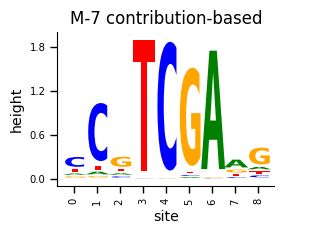

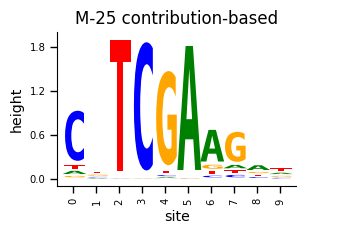

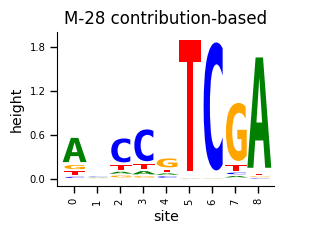

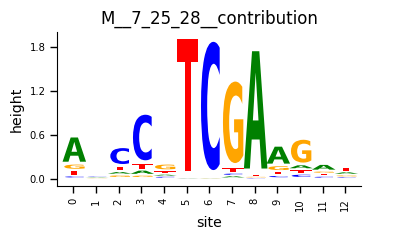


[0 1 3]


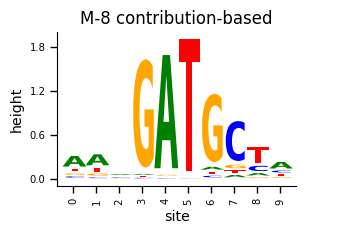

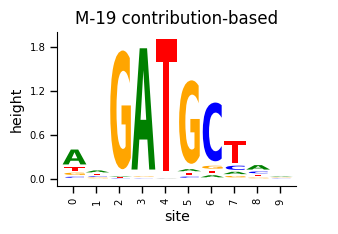

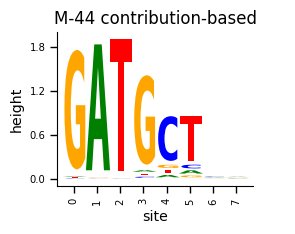

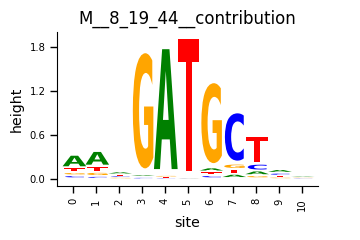


[0 0 2]


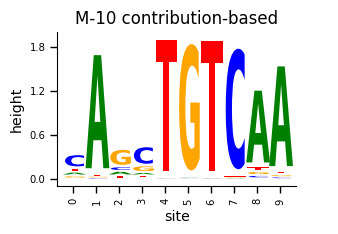

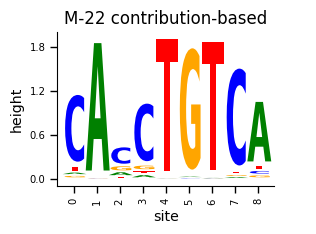

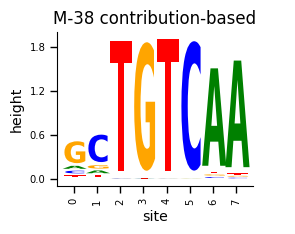

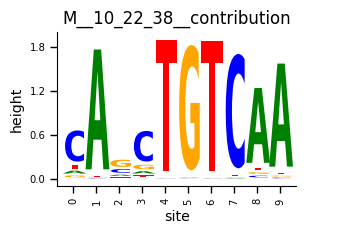


[0]


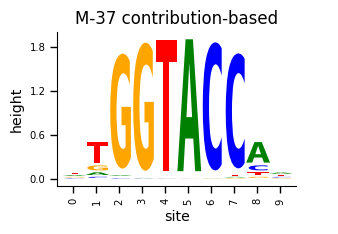

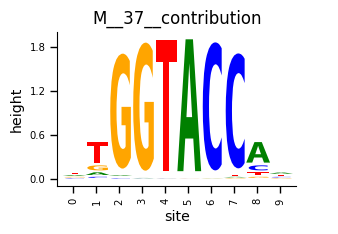


[0]


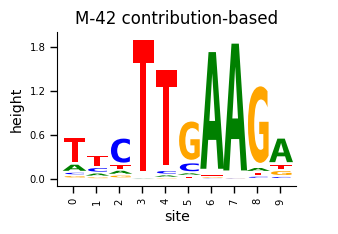

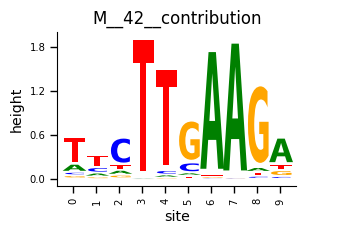

In [ ]:
all_cluster_ppms = []
all_cluster_icms = []
cluster_names = []
for idx_cluster, offset_cluster in zip(clustered_idxs, cluster_offsets):
    offset_cluster = np.array(offset_cluster)
    offset_cluster = offset_cluster - offset_cluster.min()
    print(offset_cluster)
    for idx in idx_cluster:
        matrix_to_dms(all_corrected_icms[idx - 1])
        plt.title(f'M-{idx} contribution-based')
        plt.show()
    cluster_motifs = []
    for idx, offset in zip(idx_cluster, offset_cluster):
        plot_tensor = torch.cat([torch.zeros((4, offset)), all_corrected_ppms[idx - 1]], dim=-1)
        cluster_motifs.append(plot_tensor)
    motif_lengths = [motif.shape[-1] for motif in cluster_motifs]
    max_length = max(motif_lengths)
    cluster_motifs = [torch.cat([motif, torch.zeros((4, max_length - motif.shape[-1]))], dim=-1) for motif in cluster_motifs]
    cluster_motifs = torch.stack(cluster_motifs, dim=0)

    mask = (cluster_motifs!=0)
    cluster_ppm = (cluster_motifs * mask).sum(dim=0)/mask.sum(dim=0)
    cluster_icm = ppm_to_IC(cluster_ppm)

    all_cluster_ppms.append(cluster_ppm)
    all_cluster_icms.append(cluster_icm)

    matrix_to_dms(cluster_icm)
    title = f'M__' + "_".join(map(str, idx_cluster)) + '__contribution'
    plt.title(title)
    plt.show()
    cluster_names.append(title)
    print()

In [ ]:
# motif_list = [ppm.numpy() for ppm in all_cluster_ppms]
# motif_names = cluster_names

# output_filename = "/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/STREME_min8_missing_from_modisco.txt"
# write_meme_file(motif_list, motif_names, output_filename)

# Chop modisco motifs

In [ ]:
chop_pos_dict = {#'0': [6, 24],
                 '0_E': [6, 14],
                 '1': [11, 20],
                 '2': [16, 26],
                 '3': [7, 23],
                 '4': [9, 21],
                 '5': [9, 17],
                 '6': [10, 21],
                 '7': [14, 24],
                 #'8': [9, 24],         #5 & 31
                 #'9_full': [7, 23],    #left side not relevant?
                 '10_G': [20, 28],
                 #'11_A': [17, 25],     #use 23_A
                 '12': [8, 25],
                 '14': [10, 23],
                 '15': [8, 16],
                 '16': [7, 25],         #change stop from 22 to 25? <---
                 '21': [8, 21],
                 '22': [5, 16],
                 '23_A': [17, 25],
                 #'25_B': [6, 16],       #similar to 23_A
                 '26': [13, 22],
                 '27_C': [11, 17],
                 #'27_full': [6, 17],   #left side 23_A?
                 #'28_A': [19, 27],     #use 23_A
                 '30': [6, 17],
                 '31': [11, 21],        #change start from 12 to 11? <---
                 '32_H': [6, 15],
                 '33': [12, 22],
                 '34': [6, 23],
                 #'36_C': [8, 17],
                 #'36_full': [8, 25],        #2 & 27 % 23_A
                 '39': [9, 20],
                 '44': [8, 19],
                 '46': [12, 25],
                 #'47_D': [21, 29],          #similar to 1?
                 #'50_half': [9, 15],        #similar to 30?
                 #'50_full': [2, 15],        #two 30s fwd + rev?
                 '51_I': [2, 11],             #Needs rescaling
                 '57_F': [6, 17],
                 }

chop_neg_dict = {'0': [17, 26],
                 '5': [16, 26],
                 '6': [10, 19],
                 }

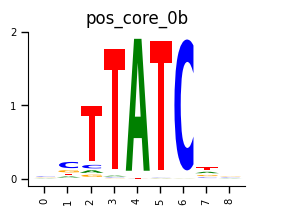

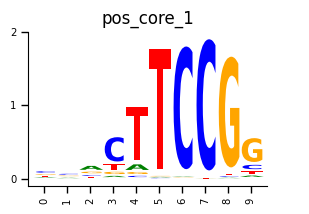

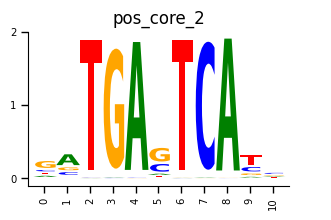

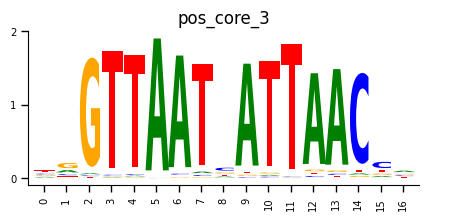

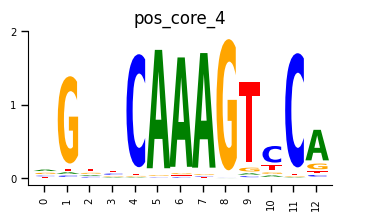

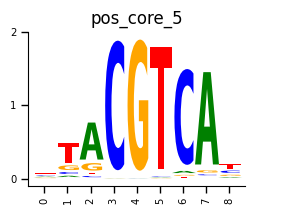

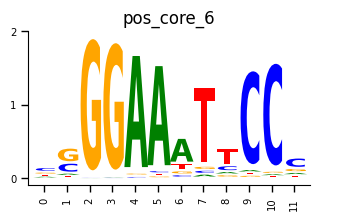

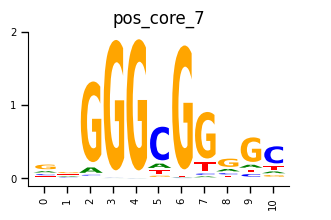

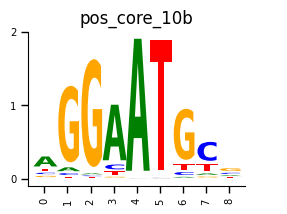

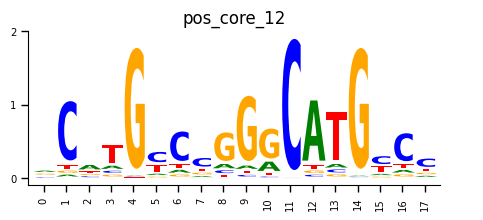

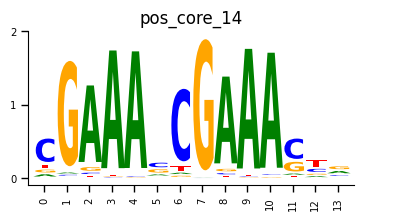

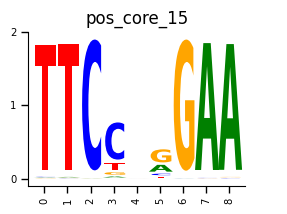

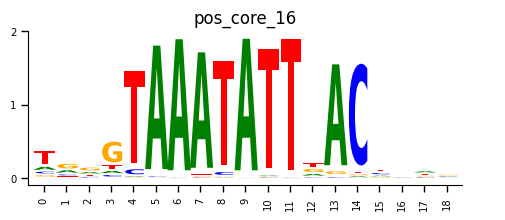

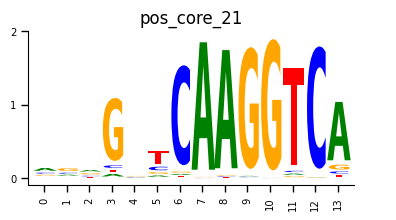

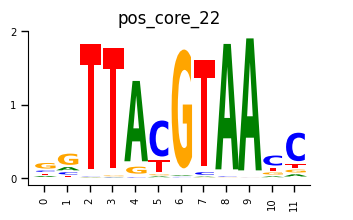

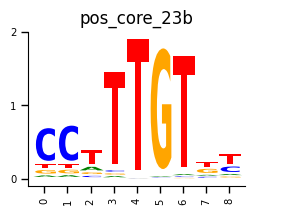

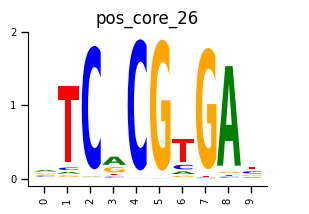

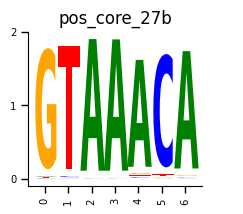

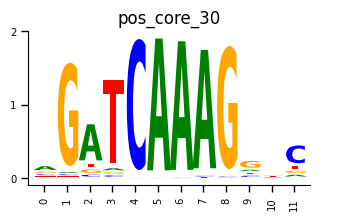

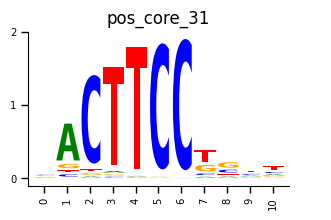

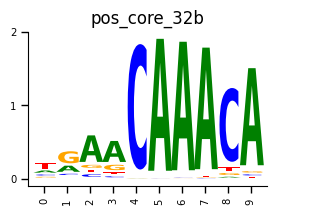

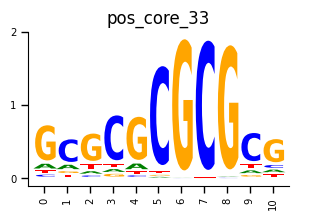

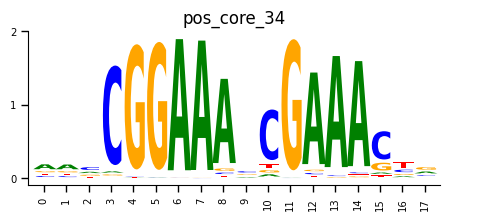

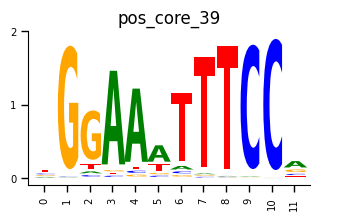

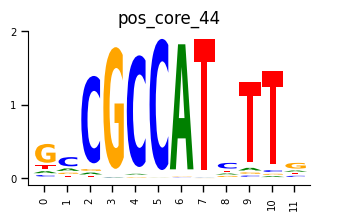

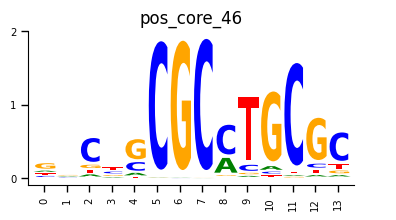

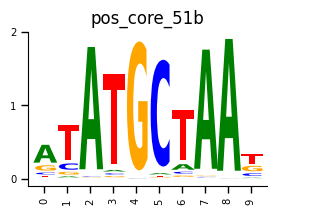

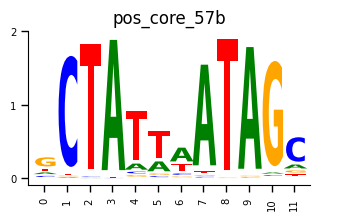

In [ ]:
loaded_patterns = pos_pattern_dict['merged_pattern_hypscores']

pos_core_pattern_ppms = []
pos_core_pattern_icms = []
pos_core_names = []
for core_key, core_start_stop in chop_pos_dict.items():
    #print(core_key)
    pattern_idx = int(core_key.split(sep='_')[0])
    core_start = core_start_stop[0] - 1
    core_stop = core_start_stop[1]
    if "_" in core_key:
        core_name = f'pos_core_{pattern_idx}b'
    else:
        core_name = f'pos_core_{pattern_idx}'
    pattern_scores = loaded_patterns[pattern_idx, ...]
    pattern_scores = pattern_scores[core_start:core_stop, :]

    # plot_tensor = torch.Tensor(pattern_scores).T
    # y_max = plot_tensor.max()
    # matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
    #                     axisfontscale=0.6, heightscale=0.8)
    # plt.xlabel('')
    # plt.ylabel('')
    # plt.title(f'core_{core_name}')
    # plt.show()

    motif_pwm = torch.Tensor(pattern_scores).T
    motif_pwm = motif_pwm * 10 / motif_pwm.abs().sum(dim=0).max().item()
    motif_ppm = torch.softmax(motif_pwm, dim=0)
    motif_icm = ppm_to_IC(motif_ppm)

    pos_core_pattern_ppms.append(motif_ppm)
    pos_core_pattern_icms.append(motif_icm)
    pos_core_names.append(core_name)

    matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.8,
                        axisfontscale=0.6, heightscale=0.8)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([0,1,2])
    plt.title(f'{core_name}')
    plt.show()

    #print()

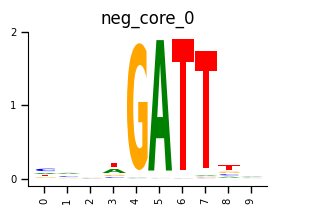

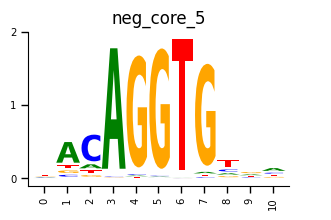

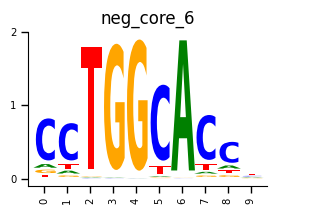

In [ ]:
loaded_patterns = np.stack(neg_pattern_dict['merged_pattern_hypscores'], axis=0)
loaded_patterns_contrib = np.stack(neg_pattern_dict['merged_pattern_scores'], axis=0)

neg_core_pattern_ppms = []
neg_core_pattern_icms = []
neg_core_names = []
for core_key, core_start_stop in chop_neg_dict.items():
    #print(core_key)
    pattern_idx = int(core_key.split(sep='_')[0])
    core_start = core_start_stop[0] - 1
    core_stop = core_start_stop[1]
    if "_" in core_key:
        core_name = f'neg_core_{pattern_idx}b'
    else:
        core_name = f'neg_core_{pattern_idx}'
    pattern_scores = loaded_patterns[pattern_idx, ...]
    pattern_scores = pattern_scores[core_start:core_stop, :]

    # plot_tensor = torch.Tensor(pattern_scores).T
    # y_max = plot_tensor.max()
    # matrix_to_dms(plot_tensor, y_max=y_max, fontaspect=.55, widthscale=0.8,
    #                     axisfontscale=0.6, heightscale=0.8)
    # plt.xlabel('')
    # plt.ylabel('')
    # plt.title(f'core_{core_name}')
    # plt.show()

    motif_pwm = torch.Tensor( - pattern_scores).T
    motif_pwm = motif_pwm * 10 / motif_pwm.abs().sum(dim=0).max().item()
    motif_ppm = torch.softmax(motif_pwm, dim=0)
    motif_icm = ppm_to_IC(motif_ppm)

    neg_core_pattern_ppms.append(motif_ppm)
    neg_core_pattern_icms.append(motif_icm)
    neg_core_names.append(core_name)

    matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.8,
                        axisfontscale=0.6, heightscale=0.8)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([0,1,2])
    plt.title(f'{core_name}')
    plt.show()

    #print()

In [ ]:
streme_core_names = []
for name in cluster_names:
    idxs = name.split('__')[1]
    streme_core_names.append(f'streme_cluster__{idxs}')

In [ ]:
all_motif_list = pos_core_pattern_ppms + neg_core_pattern_ppms + all_cluster_ppms
motif_names = pos_core_names + neg_core_names + streme_core_names

motif_list = [ppm.numpy() for ppm in all_motif_list]

# save_dict = dict(zip(motif_names, all_motif_list))
# torch.save(save_dict, "/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_motif_tensors.pt")

# output_filename = "/content/drive/MyDrive/data/BODA2_MPRA/STREME_library_analysis/modisco_plus_streme_core_motifs.txt"
# write_meme_file(motif_list, motif_names, output_filename)

In [ ]:
probs = []
for i, motif_name in enumerate(motif_names):
    motif_ppm = all_motif_list[i]
    left_size, right_size = int(np.floor(motif_ppm.shape[1] / 2)), int(np.ceil(motif_ppm.shape[1] / 2))
    random_prob_left_pad = 0.25 * torch.ones((4, 100 - left_size))
    random_prob_right_pad = 0.25 * torch.ones((4, 100 - right_size))
    probs.append(torch.cat([random_prob_left_pad, motif_ppm, random_prob_right_pad], dim=-1))

probs.append(0.25 * torch.ones((4, 200)))
probs = torch.stack(probs)

In [ ]:
n_samples = 10000

token_dim = -2
cat_axis = -1

left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[100:]).unsqueeze(0)
right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:-100]).unsqueeze(0)

probs_t = torch.transpose(probs, token_dim, cat_axis)
sampled_idxs = Categorical( probs_t )
samples = sampled_idxs.sample( (n_samples, ) )
samples = F.one_hot(samples, num_classes=4)
samples = torch.transpose(samples, token_dim, cat_axis)

pieces = [left_flank.repeat(samples.shape[0], samples.shape[1], 1, 1),
          samples,
          right_flank.repeat(samples.shape[0], samples.shape[1], 1, 1)]
in_tensor = torch.cat( pieces, axis=cat_axis)
in_tensor = in_tensor.flatten(0, 1)

In [ ]:
batch_size = 1024

temp_dataset = TensorDataset(in_tensor)
temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

preds = []
for local_batch in tqdm(temp_dataloader):
    preds.append(model(local_batch[0].cuda()).detach().cpu())

preds = torch.cat(preds, dim=0).unflatten(0, (n_samples, probs.shape[0]))

  0%|          | 0/362 [00:00<?, ?it/s]

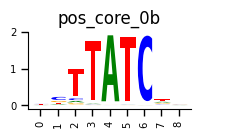

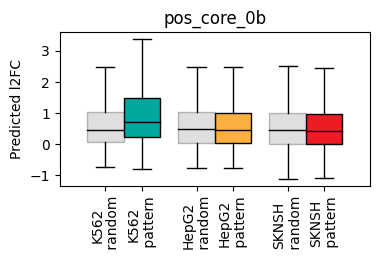

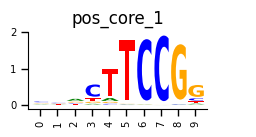

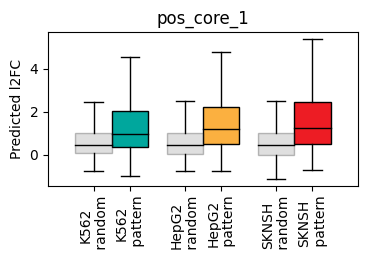

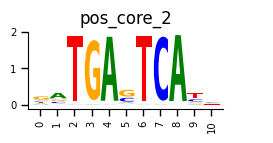

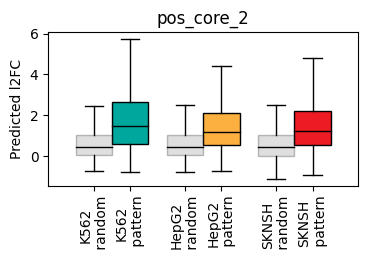

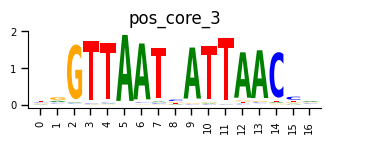

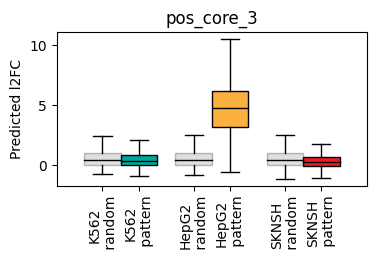

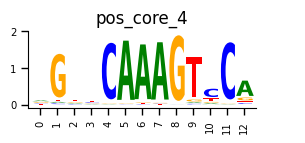

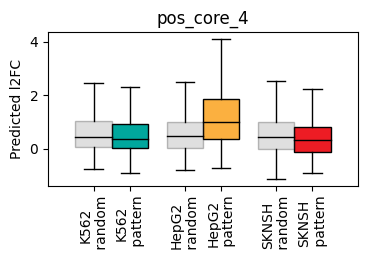

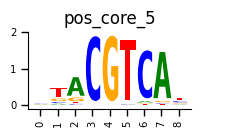

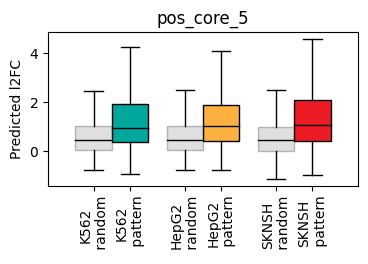

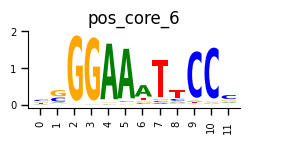

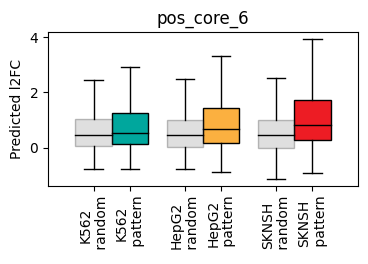

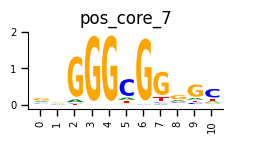

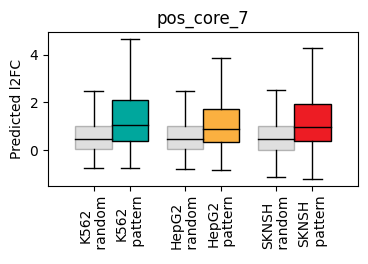

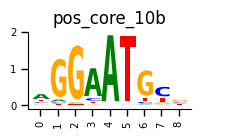

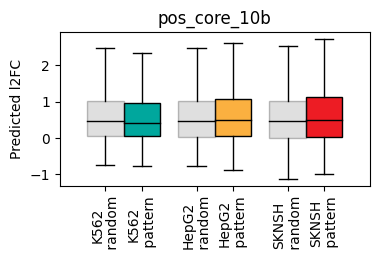

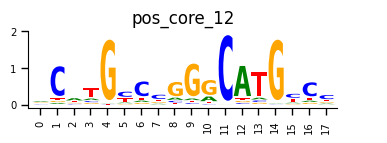

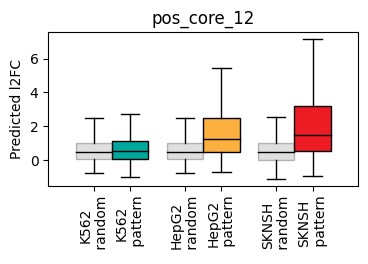

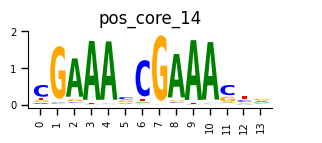

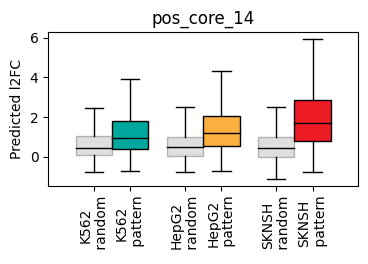

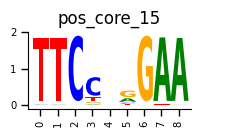

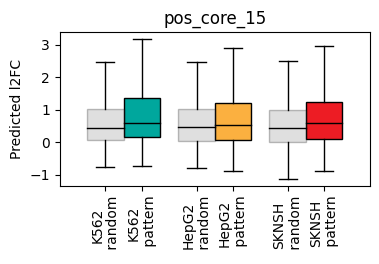

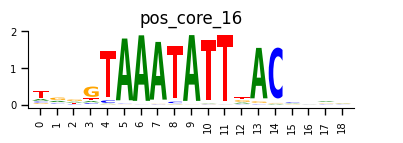

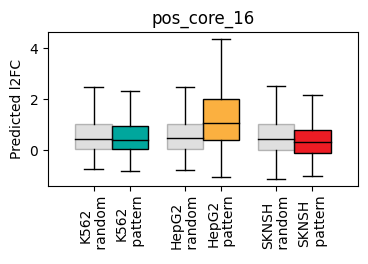

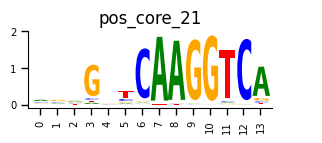

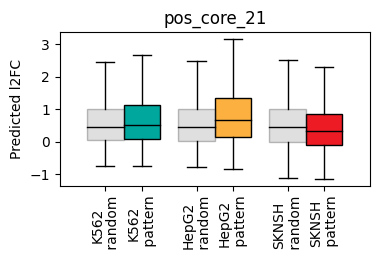

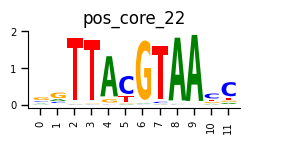

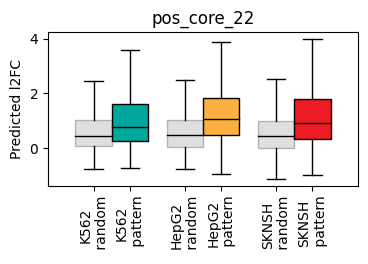

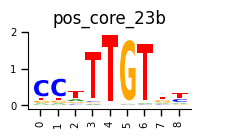

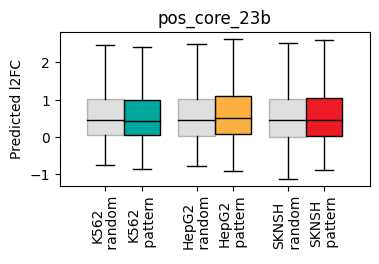

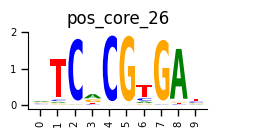

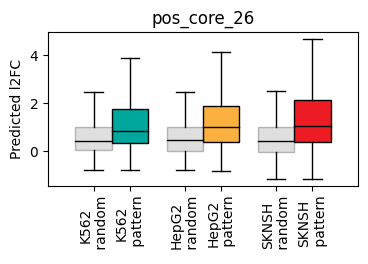

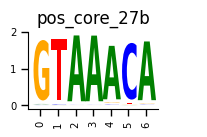

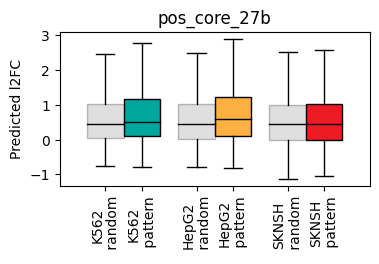

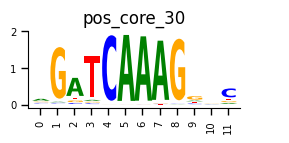

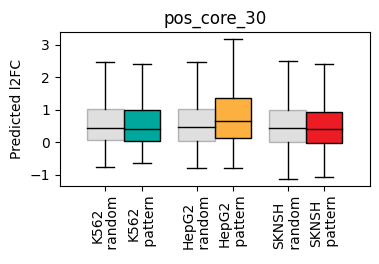

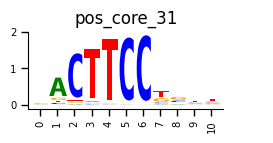

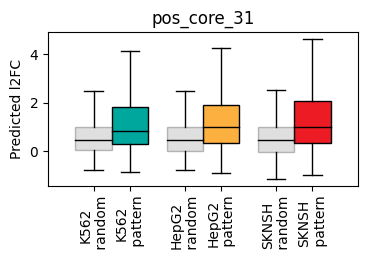

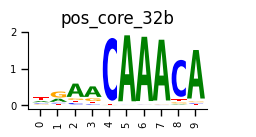

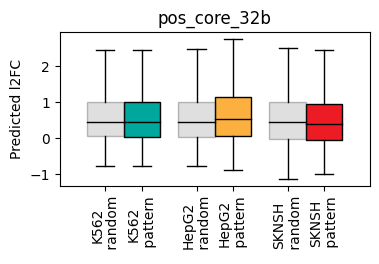

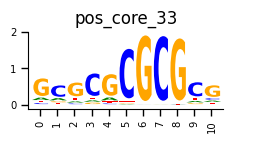

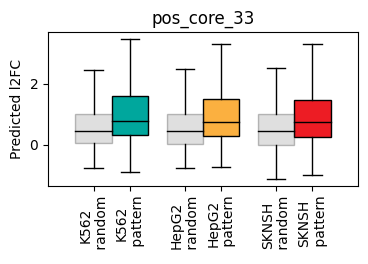

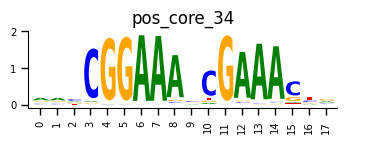

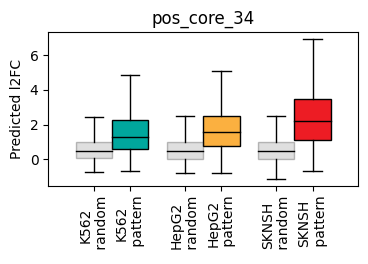

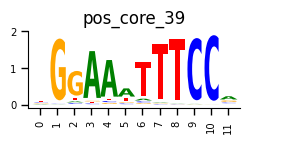

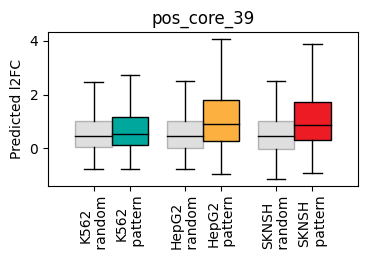

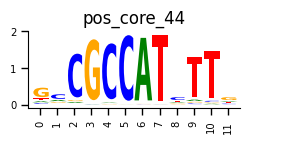

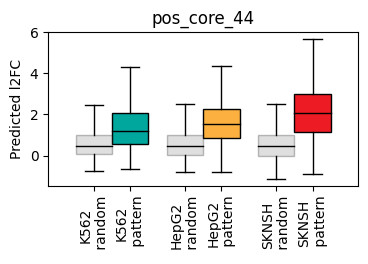

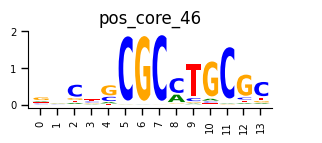

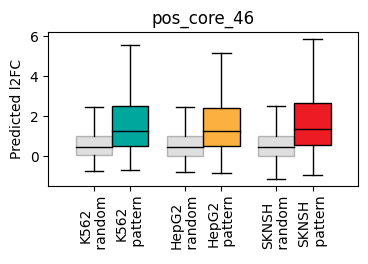

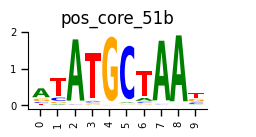

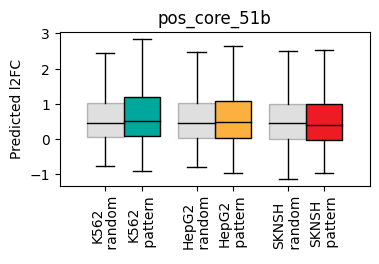

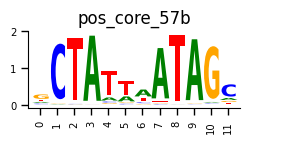

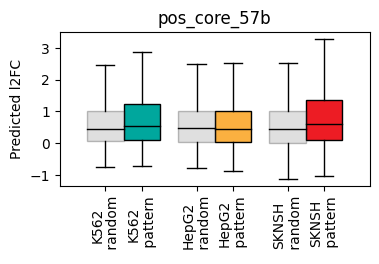

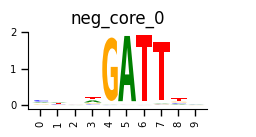

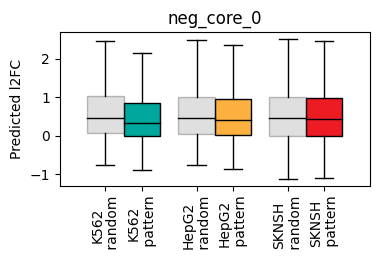

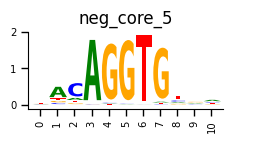

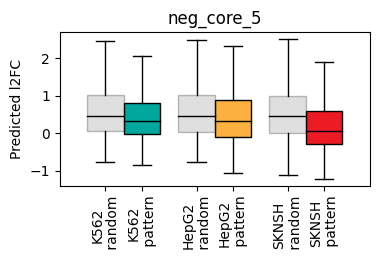

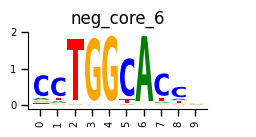

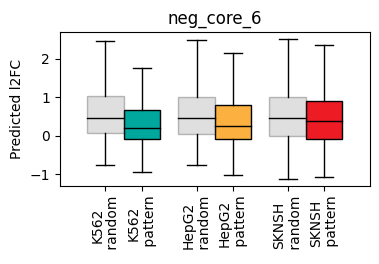

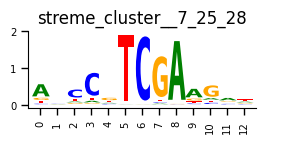

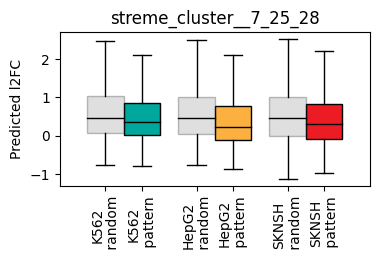

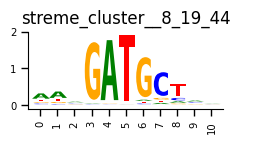

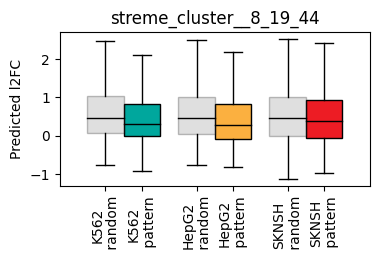

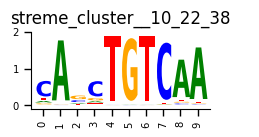

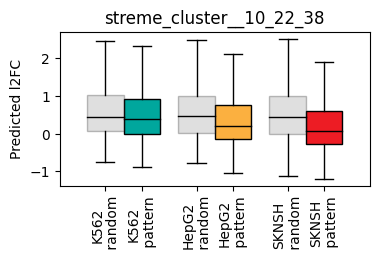

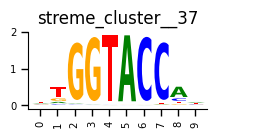

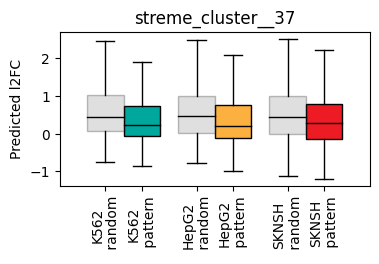

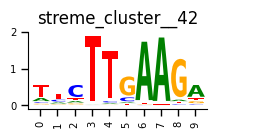

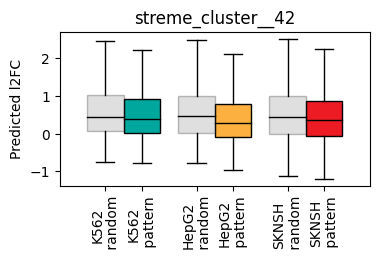

In [ ]:
all_motif_icms = pos_core_pattern_icms + neg_core_pattern_icms + all_cluster_icms

for j, motif_id in enumerate(motif_names):
    motif_icm = all_motif_icms[j]

    matrix_to_dms(motif_icm, y_max=2, fontaspect=.55, widthscale=0.6,
                        axisfontscale=0.6, heightscale=0.4)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([0,1,2])
    plt.title(f'{motif_id}')
    plt.show()

    plt.figure(figsize=(4, 2))
    boxplot = plt.boxplot(preds[:, j, :].numpy(), positions=[1.2, 2.2, 3.2] , widths=0.4, showfliers=False,
                          labels=[f'{cell_type}\n pattern' for cell_type in cell_types], patch_artist=True)
    boxplot_2 = plt.boxplot(preds[:, -1, :].numpy(), positions=[0.8, 1.8, 2.8] , widths=0.4, showfliers=False,
                          labels=[f'{cell_type}\n random' for cell_type in cell_types], patch_artist=True)
    # Set fill colors for each box
    for box, color in zip(boxplot['boxes'], cell_colors):
        box.set(facecolor=color, alpha=1)
    for median in boxplot['medians']:
        median.set(color='black')

    for box, color in zip(boxplot_2['boxes'], cell_colors):
        box.set(facecolor='grey', alpha=0.25)
    for median in boxplot_2['medians']:
        median.set(color='black')

    plt.ylabel('Predicted l2FC')
    plt.title(f'{motif_id}')
    plt.xticks(rotation=90)
    plt.show()

    print()

In [ ]:
[['1-RGTTAATSATTAACY', 'pos_pattern_3'],
 ['2-GCHGTGATTTAY', 'neg_pattern_0'],
 ['3-GGTYCAAAGTCCAHH', 'pos_pattern_4'],
 ['4-CCTTATCTST', 'pos_pattern_0'],
 ['5-ACACCTGTC', 'neg_pattern_5'],
 ['6-KATGASTCATM', 'pos_pattern_2'],
 ['9-ATGCCAGGCDR', 'neg_pattern_6'],
 ['11-WTTTCCCGCCAAWW', 'pos_pattern_7'],
 ['12-YGGGAAWTTCCCR', 'pos_pattern_6'],
 ['13-DTGCACCTGC', 'neg_pattern_1'],
 ['14-GATGCCAAS', 'neg_pattern_6'],
 ['20-GATCAAAGGKC', 'pos_pattern_30'],
 ['23-GGCGGGAA', 'pos_pattern_7'],
 ['24-GTTRTGTAAC', 'pos_pattern_22'],
 ['26-GACCTTGAMCY', 'pos_pattern_4'],
 ['29-ATTTCCGGC', 'pos_pattern_1'],
 ['30-AGGTGTGAAV', 'neg_pattern_1'],
 ['32-ACAGGTGA', 'neg_pattern_5'],
 ['33-RCCACRCCC', 'pos_pattern_7']
 ['36-GCACAGATTKSA', 'neg_pattern_0'],
 ['39-ACAAWGGGCCCWTTGT', 'pos_pattern_25'],
 ['41-GMGATAAS', 'pos_pattern_0'],
 ['46-ACCTGGCAC', 'neg_pattern_6'],
 ['53-GTTGGCAC', 'neg_pattern_6'],
 ['55-ATGASTCAT', 'pos_pattern_2'],
 ['57-ACAGGTATGTA', 'neg_pattern_1'],
 ['58-GAAAYCGAAACTR', 'pos_pattern_34'],
 ['61-CCCKGGCAC', 'neg_pattern_6'],
 ['62-CCCCDCCCCCMCC', 'pos_pattern_7'],
 ['70-CAAAGTCCA', 'pos_pattern_4'],
 ['73-GTTAATGATTAA', 'pos_pattern_3'],
 ['80-AATCACDGC', 'neg_pattern_0'],
 ]